# Import required libraries

In [9]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Get the plotting data from output files

In [10]:
# === Generate list of output scenario directories with correct naming ===
output_dirs = [f"LP-limit{limit}-GHG{ghg}-sequence" for limit in [1, 2, 4, 6] for ghg in [1, 2, 3, 4]]

# === Safely list files in each output directory ===
output_files = {}
for dir_name in output_dirs:
    folder_path = f'./output/{dir_name}'
    if os.path.exists(folder_path):
        output_files[dir_name] = os.listdir(folder_path)
    else:
        print(f"Warning: Directory not found: {folder_path}")
        output_files[dir_name] = []

# === Initialize dictionaries to store sediment flux and cost values ===
sediment_flux = {}
cost_data = {}

# === Loop through each scenario and extract sediment and cost data ===
for dir_name, files in output_files.items():
    for filename in files:
        # Parse scenario identifiers from filename
        ghg_scenario = filename.split('_')[-3]           # e.g., 'GHG1'
        limit_scenario = filename.split('_')[-2]         # e.g., 'limit2'
        scenario_index = int(filename.split('_')[-1].split('.')[0])  # e.g., 0–48

        # Load NetCDF data
        file_path = f'./output/{dir_name}/{filename}'
        dataset = xr.open_dataset(file_path)

        # Store sediment flux and cost (in billion USD)
        key = (ghg_scenario, limit_scenario, scenario_index)
        sediment_flux[key] = dataset.sediment_v.item()
        cost_data[key] = dataset.cost_v.item() / 1e9

In [11]:
# === Load uncertainty results from file ===
data = np.load('./output/uncertainty_results.npz', allow_pickle=True)
sediment_list = data['sediment_list'].item()
cost_list = data['cost_list'].item()

# === Define solution pairs for comparison (baseline vs. development) ===
solution_pairs = [
    ('solution_S0_2.xlsx', 'solution_L1_2.xlsx'),
    ('solution_S0_2.xlsx', 'solution_F0_2.xlsx'),
    ('solution_S2.xlsx', 'solution_L2.xlsx'),
    ('solution_S3.xlsx', 'solution_L3.xlsx'),
    ('solution_S4.xlsx', 'solution_L4_2.xlsx'),
    ('solution_S5.xlsx', 'solution_L5_2.xlsx'),
    ('solution_S6.xlsx', 'solution_L6_2.xlsx'),
    ('solution_S2.xlsx', 'solution_F2.xlsx'),
    ('solution_S3.xlsx', 'solution_F3.xlsx'),
    ('solution_S4.xlsx', 'solution_F4.xlsx'),
    ('solution_S5.xlsx', 'solution_F5.xlsx'),
    ('solution_S6.xlsx', 'solution_F6.xlsx'),
    ('solution_S7.xlsx', 'solution_F7.xlsx'),
    ('solution_S7.xlsx', 'solution_L7.xlsx'),
    ('solution_S8.xlsx', 'solution_F8.xlsx'),
    ('solution_S8.xlsx', 'solution_L8.xlsx'),
    ('solution_S9.xlsx', 'solution_F9.xlsx'),
    ('solution_S9.xlsx', 'solution_L9.xlsx'),
    ('solution_S10.xlsx', 'solution_F10.xlsx'),
    ('solution_S10.xlsx', 'solution_L10.xlsx'),
    ('solution_S11.xlsx', 'solution_F11.xlsx'),
    ('solution_S11.xlsx', 'solution_L11.xlsx'),
    ('solution_S12.xlsx', 'solution_F12.xlsx'),
    ('solution_S12.xlsx', 'solution_L12.xlsx'),
    ('solution_S13.xlsx', 'solution_F13.xlsx'),
    ('solution_S13.xlsx', 'solution_L13.xlsx'),
    ('solution_S14.xlsx', 'solution_F14.xlsx'),
    ('solution_S14.xlsx', 'solution_L14.xlsx'),
    ('solution_S15.xlsx', 'solution_F15.xlsx'),
    ('solution_S15.xlsx', 'solution_L15.xlsx'),
    ('solution_S16.xlsx', 'solution_F16.xlsx'),
    ('solution_S16.xlsx', 'solution_L16.xlsx'),
]

# === Load configuration table for all uncertainty runs ===
df_uncertainty = pd.read_excel('./output/uncertainty_all_scenarios.xlsx')

# Columns used to match scenario conditions between baseline and development
match_columns = ["demand", "fuel price", "inflow", 
                 "technology upper bound", "technology fix cost", "transline fix cost"]

# === Function to calculate absolute and relative cost differences ===
def compute_cost_difference(pair):
    base, dev = pair
    print(f"Comparing: {base} → {dev}")

    # Filter data for the given baseline and development solutions
    base_df = df_uncertainty[(df_uncertainty["carbon"] == base) &
                             (df_uncertainty["discount factor"] == "discount factor medium.xlsx")].copy()
    dev_df = df_uncertainty[(df_uncertainty["carbon"] == dev) &
                            (df_uncertainty["discount factor"] == "discount factor medium.xlsx")].copy()

    # Track original indices for result referencing
    base_df["idx_base"] = base_df.index
    dev_df["idx_dev"] = dev_df.index

    # Match configurations by shared values across key input columns
    matched = base_df.merge(dev_df, on=match_columns, suffixes=('_base', '_dev'))
    print(f"Matched scenario pairs: {len(matched)}")

    # Initialize results
    abs_diff_dict = {}
    rel_diff_dict = {}

    # Iterate through matched index pairs
    for _, row in matched.iterrows():
        file_base = f"mekong_2020_288h_4_years_AD110dams__{row['idx_base']}.nc"
        file_dev = f"mekong_2020_288h_4_years_AD110dams__{row['idx_dev']}.nc"

        base_cost = cost_list[base][file_base]
        dev_cost = cost_list[dev][file_dev]

        abs_diff = base_cost - dev_cost
        abs_diff_dict[(row['idx_base'], row['idx_dev'])] = abs_diff

        # Avoid division by zero
        if base_cost != 0:
            rel_diff = (abs_diff / base_cost) * 100
        else:
            rel_diff = None

        rel_diff_dict[(row['idx_base'], row['idx_dev'])] = rel_diff

    return abs_diff_dict, rel_diff_dict

# === Run difference computation for all solution pairs ===
absolute_cost_diff = {}
relative_cost_diff = {}

for pair in solution_pairs:
    abs_d, rel_d = compute_cost_difference(pair)
    absolute_cost_diff[pair] = abs_d
    relative_cost_diff[pair] = rel_d


Comparing: solution_S0_2.xlsx → solution_L1_2.xlsx
Matched scenario pairs: 729
Comparing: solution_S0_2.xlsx → solution_F0_2.xlsx
Matched scenario pairs: 729
Comparing: solution_S2.xlsx → solution_L2.xlsx
Matched scenario pairs: 729
Comparing: solution_S3.xlsx → solution_L3.xlsx
Matched scenario pairs: 729
Comparing: solution_S4.xlsx → solution_L4_2.xlsx
Matched scenario pairs: 729
Comparing: solution_S5.xlsx → solution_L5_2.xlsx
Matched scenario pairs: 729
Comparing: solution_S6.xlsx → solution_L6_2.xlsx
Matched scenario pairs: 729
Comparing: solution_S2.xlsx → solution_F2.xlsx
Matched scenario pairs: 729
Comparing: solution_S3.xlsx → solution_F3.xlsx
Matched scenario pairs: 729
Comparing: solution_S4.xlsx → solution_F4.xlsx
Matched scenario pairs: 729
Comparing: solution_S5.xlsx → solution_F5.xlsx
Matched scenario pairs: 729
Comparing: solution_S6.xlsx → solution_F6.xlsx
Matched scenario pairs: 729
Comparing: solution_S7.xlsx → solution_F7.xlsx
Matched scenario pairs: 729
Comparing: 

In [12]:
pari_index_low = {('GHG1','limit1'):('solution_S2.xlsx', 'solution_L2.xlsx'),
                 ('GHG1','limit2'):('solution_S3.xlsx', 'solution_L3.xlsx'),
                 ('GHG1','limit4'):('solution_S4.xlsx', 'solution_L4_2.xlsx'),
                 ('GHG1','limit6'):('solution_S0_2.xlsx', 'solution_L1_2.xlsx'),
                 ('GHG2','limit1'):('solution_S7.xlsx', 'solution_L7.xlsx'),
                 ('GHG2','limit2'):('solution_S8.xlsx', 'solution_L8.xlsx'),
                 ('GHG2','limit4'):('solution_S9.xlsx', 'solution_L9.xlsx'),
                 ('GHG2','limit6'):('solution_S6.xlsx', 'solution_L6_2.xlsx'),
                 ('GHG3','limit1'):('solution_S10.xlsx', 'solution_L10.xlsx'),
                 ('GHG3','limit2'):('solution_S11.xlsx', 'solution_L11.xlsx'),
                 ('GHG3','limit4'):('solution_S12.xlsx', 'solution_L12.xlsx'),
                 ('GHG3','limit6'):('solution_S5.xlsx', 'solution_L5_2.xlsx'),
                 ('GHG4','limit1'):('solution_S13.xlsx', 'solution_L13.xlsx'),
                 ('GHG4','limit2'):('solution_S14.xlsx', 'solution_L14.xlsx'),
                 ('GHG4','limit4'):('solution_S15.xlsx', 'solution_L15.xlsx'),
                 ('GHG4','limit6'):('solution_S16.xlsx', 'solution_L16.xlsx'),
                 }
pari_index_high = {('GHG1','limit1'):('solution_S2.xlsx', 'solution_F2.xlsx'),
                 ('GHG1','limit2'):('solution_S3.xlsx', 'solution_F3.xlsx'),
                 ('GHG1','limit4'):('solution_S4.xlsx', 'solution_F4.xlsx'),
                 ('GHG1','limit6'):('solution_S0_2.xlsx', 'solution_F0_2.xlsx'),
                 ('GHG2','limit1'):('solution_S7.xlsx', 'solution_F7.xlsx'),
                 ('GHG2','limit2'):('solution_S8.xlsx', 'solution_F8.xlsx'),
                 ('GHG2','limit4'):('solution_S9.xlsx', 'solution_F9.xlsx'),
                 ('GHG2','limit6'):('solution_S6.xlsx', 'solution_F6.xlsx'),
                 ('GHG3','limit1'):('solution_S10.xlsx', 'solution_F10.xlsx'),
                 ('GHG3','limit2'):('solution_S11.xlsx', 'solution_F11.xlsx'),
                 ('GHG3','limit4'):('solution_S12.xlsx', 'solution_F12.xlsx'),
                 ('GHG3','limit6'):('solution_S5.xlsx', 'solution_F5.xlsx'),
                 ('GHG4','limit1'):('solution_S13.xlsx', 'solution_F13.xlsx'),
                 ('GHG4','limit2'):('solution_S14.xlsx', 'solution_F14.xlsx'),
                 ('GHG4','limit4'):('solution_S15.xlsx', 'solution_F15.xlsx'),
                 ('GHG4','limit6'):('solution_S16.xlsx', 'solution_F16.xlsx'),
                 }
pari_index_sediment_low = {('GHG1','limit1'): 'solution_L2.xlsx',
                 ('GHG1','limit2'): 'solution_L3.xlsx',
                 ('GHG1','limit4'):'solution_L4_2.xlsx',
                 ('GHG1','limit6'): 'solution_L1_2.xlsx',
                 ('GHG2','limit1'): 'solution_L7.xlsx',
                 ('GHG2','limit2'): 'solution_L8.xlsx',
                 ('GHG2','limit4'):'solution_L9.xlsx',
                 ('GHG2','limit6'): 'solution_L6_2.xlsx',
                 ('GHG3','limit1'):'solution_L10.xlsx',
                 ('GHG3','limit2'): 'solution_L11.xlsx',
                 ('GHG3','limit4'): 'solution_L12.xlsx',
                 ('GHG3','limit6'): 'solution_L5_2.xlsx',
                 ('GHG4','limit1'): 'solution_L13.xlsx',
                 ('GHG4','limit2'): 'solution_L14.xlsx',
                 ('GHG4','limit4'): 'solution_L15.xlsx',
                 ('GHG4','limit6'): 'solution_L16.xlsx',
                 }
pari_index_sediment_high = {('GHG1','limit1'):'solution_F2.xlsx',
                 ('GHG1','limit2'):'solution_F3.xlsx',
                 ('GHG1','limit4'): 'solution_F4.xlsx',
                 ('GHG1','limit6'): 'solution_F0_2.xlsx',
                 ('GHG2','limit1'): 'solution_F7.xlsx',
                 ('GHG2','limit2'): 'solution_F8.xlsx',
                 ('GHG2','limit4'): 'solution_F9.xlsx',
                 ('GHG2','limit6'): 'solution_F6.xlsx',
                 ('GHG3','limit1'): 'solution_F10.xlsx',
                 ('GHG3','limit2'): 'solution_F11.xlsx',
                 ('GHG3','limit4'): 'solution_F12.xlsx',
                 ('GHG3','limit6'): 'solution_F5.xlsx',
                 ('GHG4','limit1'): 'solution_F13.xlsx',
                 ('GHG4','limit2'): 'solution_F14.xlsx',
                 ('GHG4','limit4'): 'solution_F15.xlsx',
                 ('GHG4','limit6'): 'solution_F16.xlsx',
                 }

pari_index_sediment_QUO = {('GHG1','limit1'):'solution_S2.xlsx',
                 ('GHG1','limit2'):'solution_S3.xlsx',
                 ('GHG1','limit4'): 'solution_S4.xlsx',
                 ('GHG1','limit6'): 'solution_S0_2.xlsx',
                 ('GHG2','limit1'): 'solution_S7.xlsx',
                 ('GHG2','limit2'): 'solution_S8.xlsx',
                 ('GHG2','limit4'): 'solution_S9.xlsx',
                 ('GHG2','limit6'): 'solution_S6.xlsx',
                 ('GHG3','limit1'): 'solution_S10.xlsx',
                 ('GHG3','limit2'): 'solution_S11.xlsx',
                 ('GHG3','limit4'): 'solution_S12.xlsx',
                 ('GHG3','limit6'): 'solution_S5.xlsx',
                 ('GHG4','limit1'): 'solution_S13.xlsx',
                 ('GHG4','limit2'): 'solution_S14.xlsx',
                 ('GHG4','limit4'): 'solution_S15.xlsx',
                 ('GHG4','limit6'): 'solution_S16.xlsx',
                 }

In [13]:
import numpy as np

# Initialize output dictionaries
cost_saving = {}                         # Cost savings for each (GHG, limit, index)
low_impact_savings = {}                  # Pre-calculated cost difference for low-impact scenarios
all_savings = {}                         # Pre-calculated cost difference for all scenarios
cost_below_threshold = {}                # Cost savings where sediment is below threshold
sediment_below_threshold = {}            # Sediment values below threshold

# Sediment constraint threshold
sediment_threshold = 51

# Scenario identifiers
limit_scenarios = ['limit1', 'limit2', 'limit4', 'limit6']
ghg_scenarios = ['GHG1', 'GHG2', 'GHG3', 'GHG4']

# Iterate through all GHG and development limit scenario combinations
for limit in limit_scenarios:
    for ghg in ghg_scenarios:

        min_cost = float('inf')
        min_index = None
        temp_cost_list = []
        temp_sediment_list = []

        for idx in range(49):
            key = (ghg, limit, idx)

            if idx == 0:
                cost_saving[key] = 0
            else:
                # Average cost from fully developed scenario
                current_cost = np.mean(list(cost_list[pari_index_sediment_high[(ghg, limit)]].values())) + cost_data[(ghg, limit, idx)] - cost_data[(ghg, limit, 48)]
                baseline_cost = np.mean(list(cost_list[pari_index_sediment_QUO[(ghg, limit)]].values()))
                cost_saving[key] = baseline_cost - current_cost

            # Filter by sediment output threshold
            sediment_val = sediment_flux[(ghg, limit, idx)]
            if sediment_val < sediment_threshold:
                temp_cost_list.append(cost_saving[key])
                temp_sediment_list.append(sediment_val)
            else:
                if cost_data[(ghg, limit, idx)] < min_cost:
                    min_cost = cost_data[(ghg, limit, idx)]
                    min_index = key

        # Store results
        cost_below_threshold[(ghg, limit)] = temp_cost_list
        sediment_below_threshold[(ghg, limit)] = temp_sediment_list
        low_impact_savings[(ghg, limit)] = absolute_cost_diff[pari_index_low[(ghg, limit)]]
        all_savings[(ghg, limit)] = absolute_cost_diff[pari_index_high[(ghg, limit)]]


In [14]:
# Load sediment flux values from different solution files
sediment_values = {}

# Read values from the Excel file for each scenario's specific column (identified by [x, y, z])
sediment_values['solution_L1_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 27]"].dropna().values
sediment_values['solution_F0_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 48]"].dropna().values
sediment_values['solution_S0_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 6, 0]"].dropna().values
sediment_values['solution_L2.xlsx']    = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 1, 27]"].dropna().values
sediment_values['solution_L3.xlsx']    = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 2, 27]"].dropna().values
sediment_values['solution_L4_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[1, 4, 27]"].dropna().values
sediment_values['solution_L5_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[3, 6, 27]"].dropna().values
sediment_values['solution_L6_2.xlsx']  = pd.read_excel("./output/uncertainty_analysis_8experiments.xlsx", sheet_name="Sediment Flux")["[2, 6, 27]"].dropna().values

# Define scenario categories
transmission_limits = ['limit1', 'limit2', 'limit4', 'limit6']
ghg_targets = ['GHG1', 'GHG2', 'GHG3', 'GHG4']

# Initialize dictionaries to store averaged sediment outputs for different development scenarios
sediment_quota = {}
sediment_low_impact = {}
sediment_full_expansion = {}

# Loop over all combinations of GHG and transmission scenarios
for ghg in ghg_targets:
    for limit in transmission_limits:
        # Quota scenario always uses S0_2
        sediment_quota[(ghg, limit)] = sediment_values['solution_S0_2.xlsx'].mean()
        
        # Full expansion scenario always uses F0_2
        sediment_full_expansion[(ghg, limit)] = sediment_values['solution_F0_2.xlsx'].mean()
        
        # Low impact development depends on both GHG and transmission limits
        if limit == 'limit1':
            sediment_low_impact[(ghg, limit)] = sediment_values['solution_L2.xlsx'].mean()
        elif limit == 'limit2':
            sediment_low_impact[(ghg, limit)] = sediment_values['solution_L3.xlsx'].mean()
        elif limit == 'limit4':
            sediment_low_impact[(ghg, limit)] = sediment_values['solution_L4_2.xlsx'].mean()
        elif limit == 'limit6':
            if ghg == 'GHG1':
                sediment_low_impact[(ghg, limit)] = sediment_values['solution_L1_2.xlsx'].mean()
            elif ghg == 'GHG2':
                sediment_low_impact[(ghg, limit)] = sediment_values['solution_L6_2.xlsx'].mean()
            else:  # GHG3 or GHG4
                sediment_low_impact[(ghg, limit)] = sediment_values['solution_L5_2.xlsx'].mean()


# Plotting

In [15]:
%matplotlib inline
from pylab import rcParams
font_size=8
params = {'backend': 'ps',
          'axes.labelsize': font_size,
          'grid.linewidth': 0.2,
          'font.size': font_size,
          'legend.fontsize': font_size,
          'legend.frameon': False,
          'xtick.labelsize': font_size,
          'xtick.direction': 'out',
          'ytick.labelsize': font_size,
          'ytick.direction': 'out',
          'savefig.bbox': 'tight',
          'text.usetex': False,
          'axes.titlesize':font_size,
          'font.family':'Myriad Pro'}

import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
plt.rcParams.update(params)

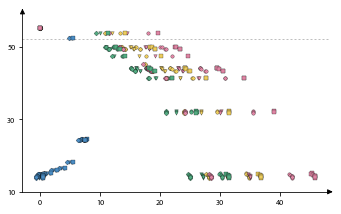

C:\Users\dlutx\AppData\Local\Temp\ipykernel_22088\1528796950.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig('Fig 3A.pdf', dpi=1000, layout="constrained")


In [16]:
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# === Create figure ===
fig, ax = plt.subplots(1, 1, figsize=(120 / 25.4, 80 / 25.4), sharex=True)

# === Define scenarios and styling ===
transmission_limits = ['limit1', 'limit2', 'limit4', 'limit6']
ghg_targets = ['GHG1', 'GHG2', 'GHG3', 'GHG4']
markers = {'GHG1': 's', 'GHG2': 'o', 'GHG3': "v", 'GHG4': 'D'}
colors = {'limit1': '#4A8CC3', 'limit2': '#53AC82', 'limit4': '#EDCD5E', 'limit6': '#DF85A4'}

# === Scatter plotting ===
for ghg in ghg_targets:
    for limit in transmission_limits:
        # Coordinates for the scatter points
        x_vals = cost_below_threshold[(ghg, limit)]
        y_vals = sediment_below_threshold[(ghg, limit)]

        # Compute key reference points
        x_low = np.mean(list(low_impact_savings[(ghg, limit)].values()))
        y_low = sediment_low_impact[(ghg, limit)]
        x_high = np.mean(list(all_savings[(ghg, limit)].values()))
        y_high = sediment_full_expansion[(ghg, limit)]
        y_quota = sediment_quota[(ghg, limit)]

        z = 3 if ghg == 'GHG1' else 2  # z-order for GHG1 to appear on top

        # Plot: Low impact
        ax.scatter(x_low, y_low, s=12, edgecolors='black', c=colors[limit],
                   linewidths=0.25, zorder=z, marker=markers[ghg])
        # Plot: Full expansion
        ax.scatter(x_high, y_high, s=12, edgecolors='black', c=colors[limit],
                   linewidths=0.25, zorder=z, marker=markers[ghg])
        # Plot: LP points
        ax.scatter(x_vals, y_vals, s=12, edgecolors='black', c=colors[limit],
                   linewidths=0.25, zorder=z, marker=markers[ghg])
        # Plot: Quota
        ax.scatter(0, y_quota, s=12, edgecolors='black', c=colors[limit],
                   linewidths=0.25, zorder=z, marker=markers[ghg])

# === Axis config ===
ax.set_ylim(10, 60)
ax.axhline(y=54.8 * 0.95, xmin=0, xmax=1, color='grey', linewidth=0.5, linestyle='--', dashes=(4, 4))
ax.set_yticks([10, 30, 50])
ax.set_yticklabels([10, 30, 50])
ax.tick_params(labelbottom=True)

# === Style the spines ===
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

# === Add arrows to indicate axes ===
ax.annotate('', xy=(1, 0), xycoords='axes fraction', xytext=(1.02, 0),
            arrowprops=dict(arrowstyle="<|-", color='black'))
ax.annotate('', xy=(0, 1), xycoords='axes fraction', xytext=(0, 1.02),
            arrowprops=dict(arrowstyle="<|-", color='black'))

# === Finalize and export figure ===
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.95, top=0.9, wspace=0.1, hspace=0.2)
plt.show()
fig.savefig('Fig 3A.pdf', dpi=1000, layout="constrained")
